In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pm2-5-india/final_india_data.csv


In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

def preprocess_air_quality_data(file_path):
    # Load data
    df = pd.read_csv(file_path, low_memory=False)
    df.drop(columns=['StationId'], inplace=True)
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64']).columns
    imputer = SimpleImputer(strategy='mean')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Process datetime and create time features
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', errors='coerce')
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    
    # Categorize PM2.5 values
    bins = [0, 12, 35.4, 55.4, 150.4, 250.4, float('inf')]
    labels = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    df['PM2.5_Category'] = pd.cut(df['PM2.5'], bins=bins, labels=labels)
    
    # Perform undersampling
    return df


# For each dataset
df1 = preprocess_air_quality_data('/kaggle/input/new-data/new_data.csv')
# df2 = preprocess_air_quality_data('/kaggle/input/all-other-set/second_set.csv')
# df3 = preprocess_air_quality_data('/kaggle/input/all-other-set/third_set.csv')

# Combine all datasets
# final_df = pd.concat([df1, df2, df3], ignore_index=True)

# Print sizes to see the reduction
print("Original sizes:", len(df1))

Original sizes: 1048575


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.losses import Huber


def preprocess_data(data_path, sequence_length=24):
    """
    Enhanced preprocessing pipeline with robust data cleaning
    """
    # Load data
#     data = pd.read_csv(data_path)
    data = df1
    data = data[:365000]
    # Clean column names and remove problematic columns
#     columns_to_drop = ['Unnamed: 0','AQI_Bucket', 'Datetime']
    columns_to_drop = ['AQI_Bucket', 'Datetime']
    data.drop(columns=columns_to_drop, axis=1, inplace=True)
    # Ensure numeric columns
    numeric_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
    
#     # Convert to numeric, coerce errors to NaN
#     for col in numeric_columns:
#         data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Create datetime index
    data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
    data.set_index('datetime', inplace=True)
    # Handle missing values before any transformations
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].interpolate(method='time')
    
    # Remove outliers
    def remove_outliers(df, columns, n_std=3):
        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df.loc[df[col] > mean + (n_std * std), col] = mean + (n_std * std)
            df.loc[df[col] < mean - (n_std * std), col] = mean - (n_std * std)
        return df
    
    data = remove_outliers(data, numeric_columns)
    
    data = pd.get_dummies(data, columns=['PM2.5_Category'], drop_first=True)
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Cyclical encoding of time features
    def create_cyclical_features(df, col, period):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/period)
        return df
    
    data = create_cyclical_features(data, 'hour', 24)
    data = create_cyclical_features(data, 'dayofweek', 7)
    data = create_cyclical_features(data, 'month', 12)
    
    # Lag features for PM2.5
    for lag in [1, 3, 6, 12, 24]:
        data[f'pm25_lag_{lag}'] = data['PM2.5'].shift(lag)
    
    # Rolling statistics for PM2.5
    for window in [6, 12, 24]:
        data[f'pm25_roll_mean_{window}'] = data['PM2.5'].rolling(window=window).mean()
        data[f'pm25_roll_std_{window}'] = data['PM2.5'].rolling(window=window).std()
    
    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    # Scale features
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    # Create sequences
    X, y = [], []
    target_column_index = list(data.columns).index('PM2.5')
    
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length, target_column_index])
    
    X, y = np.array(X), np.array(y)
    
    # Split data with consideration for time series
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    
    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            scaler, data.columns, target_column_index)


def build_simplified_model(input_shape):
    """
    Simplified LSTM model with two LSTM layers and basic regularization
    """
    model = tf.keras.Sequential()

    # First LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=True,  
        input_shape=input_shape,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Second LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=False,  
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Dense layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.2)) 
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  
        loss=Huber(),
        metrics=['mae', 'mse']
    )

    return model


def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
    """
    Complete training and prediction pipeline
    """
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]

    model = build_simplified_model((X_train.shape[1], X_train.shape[2]))

    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
        dummy = np.zeros((len(predictions), len(data_columns)))
        dummy[:, target_column_index] = predictions.flatten()
        return scaler.inverse_transform(dummy)[:, target_column_index]

    predictions = model.predict(X_test)
    predictions_orig = inverse_transform_predictions(
        predictions, scaler, data_columns, target_column_index
    )
    y_test_orig = inverse_transform_predictions(
        y_test.reshape(-1, 1), scaler, data_columns, target_column_index
    )

    return model, history, predictions_orig, y_test_orig

def save_model_artifacts(model, scaler, base_path='./'):
    """
    Save both the trained model and scaler
    """
    os.makedirs(base_path, exist_ok=True)
    
    model_path = os.path.join(base_path, 'best_lstm_model.keras')
    scaler_path = os.path.join(base_path, 'scaler.pkl')
    
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"Model saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")
    
    return model_path, scaler_path


def evaluate_predictions(y_true, y_pred, dates=None):
    """
    Comprehensive evaluation of predictions with enhanced visualization
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Mean Bias Error': np.mean(y_pred - y_true),
        'Max Error': np.max(np.abs(y_pred - y_true)),
        'Error Std': np.std(y_pred - y_true)
    }
    
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
    print("\nEvaluation Metrics:")
    print(metrics_df.to_string(index=False))
    
    plt.figure(figsize=(20, 16))

    # Time Series Plot
    plt.subplot(2, 2, 1)
    if dates is not None:
        plt.plot(dates[:200], y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(dates[:200], y_pred[:200], label='Predicted', color='r', alpha=0.7)
    else:
        plt.plot(y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(y_pred[:200], label='Predicted', color='r', alpha=0.7)
    plt.title('Time Series Plot (First 200 samples)', fontsize=14)
    plt.xlabel('Date' if dates is not None else 'Index', fontsize=12)
    plt.ylabel('PM2.5 Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Scatter Plot
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.6, color='purple', edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Fit')
    plt.xlabel('Actual PM2.5', fontsize=12)
    plt.ylabel('Predicted PM2.5', fontsize=12)
    plt.title('Actual vs Predicted', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Error Distribution
    plt.subplot(2, 2, 3)
    errors = y_pred - y_true
    plt.hist(errors, bins=30, color='green', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.title('Error Distribution', fontsize=14)
    plt.xlabel('Prediction Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Residual Plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_pred, errors, alpha=0.6, color='orange', edgecolors='k')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted PM2.5', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return metrics

Epoch 1/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 0.1926 - mae: 0.4292 - mse: 0.4457 - val_loss: 0.0689 - val_mae: 0.1956 - val_mse: 0.1450 - learning_rate: 0.0010
Epoch 2/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 0.1036 - mae: 0.2919 - mse: 0.2342 - val_loss: 0.0663 - val_mae: 0.1863 - val_mse: 0.1444 - learning_rate: 0.0010
Epoch 3/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 0.0980 - mae: 0.2811 - mse: 0.2268 - val_loss: 0.0673 - val_mae: 0.1895 - val_mse: 0.1452 - learning_rate: 0.0010
Epoch 4/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 0.0961 - mae: 0.2765 - mse: 0.2226 - val_loss: 0.0655 - val_mae: 0.1852 - val_mse: 0.1430 - learning_rate: 0.0010
Epoch 5/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - loss: 0.0934 - mae: 0.2726 - mse: 0.2124 - val_loss: 0.0644 - val_mae: 0.1862 - val_mse: 0.1399 - learning_rate: 0.0010
Epoch 6/15
7984/7984 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - loss: 0.0922 - mae: 0.2709 - mse: 0.2109 - val_loss: 0.

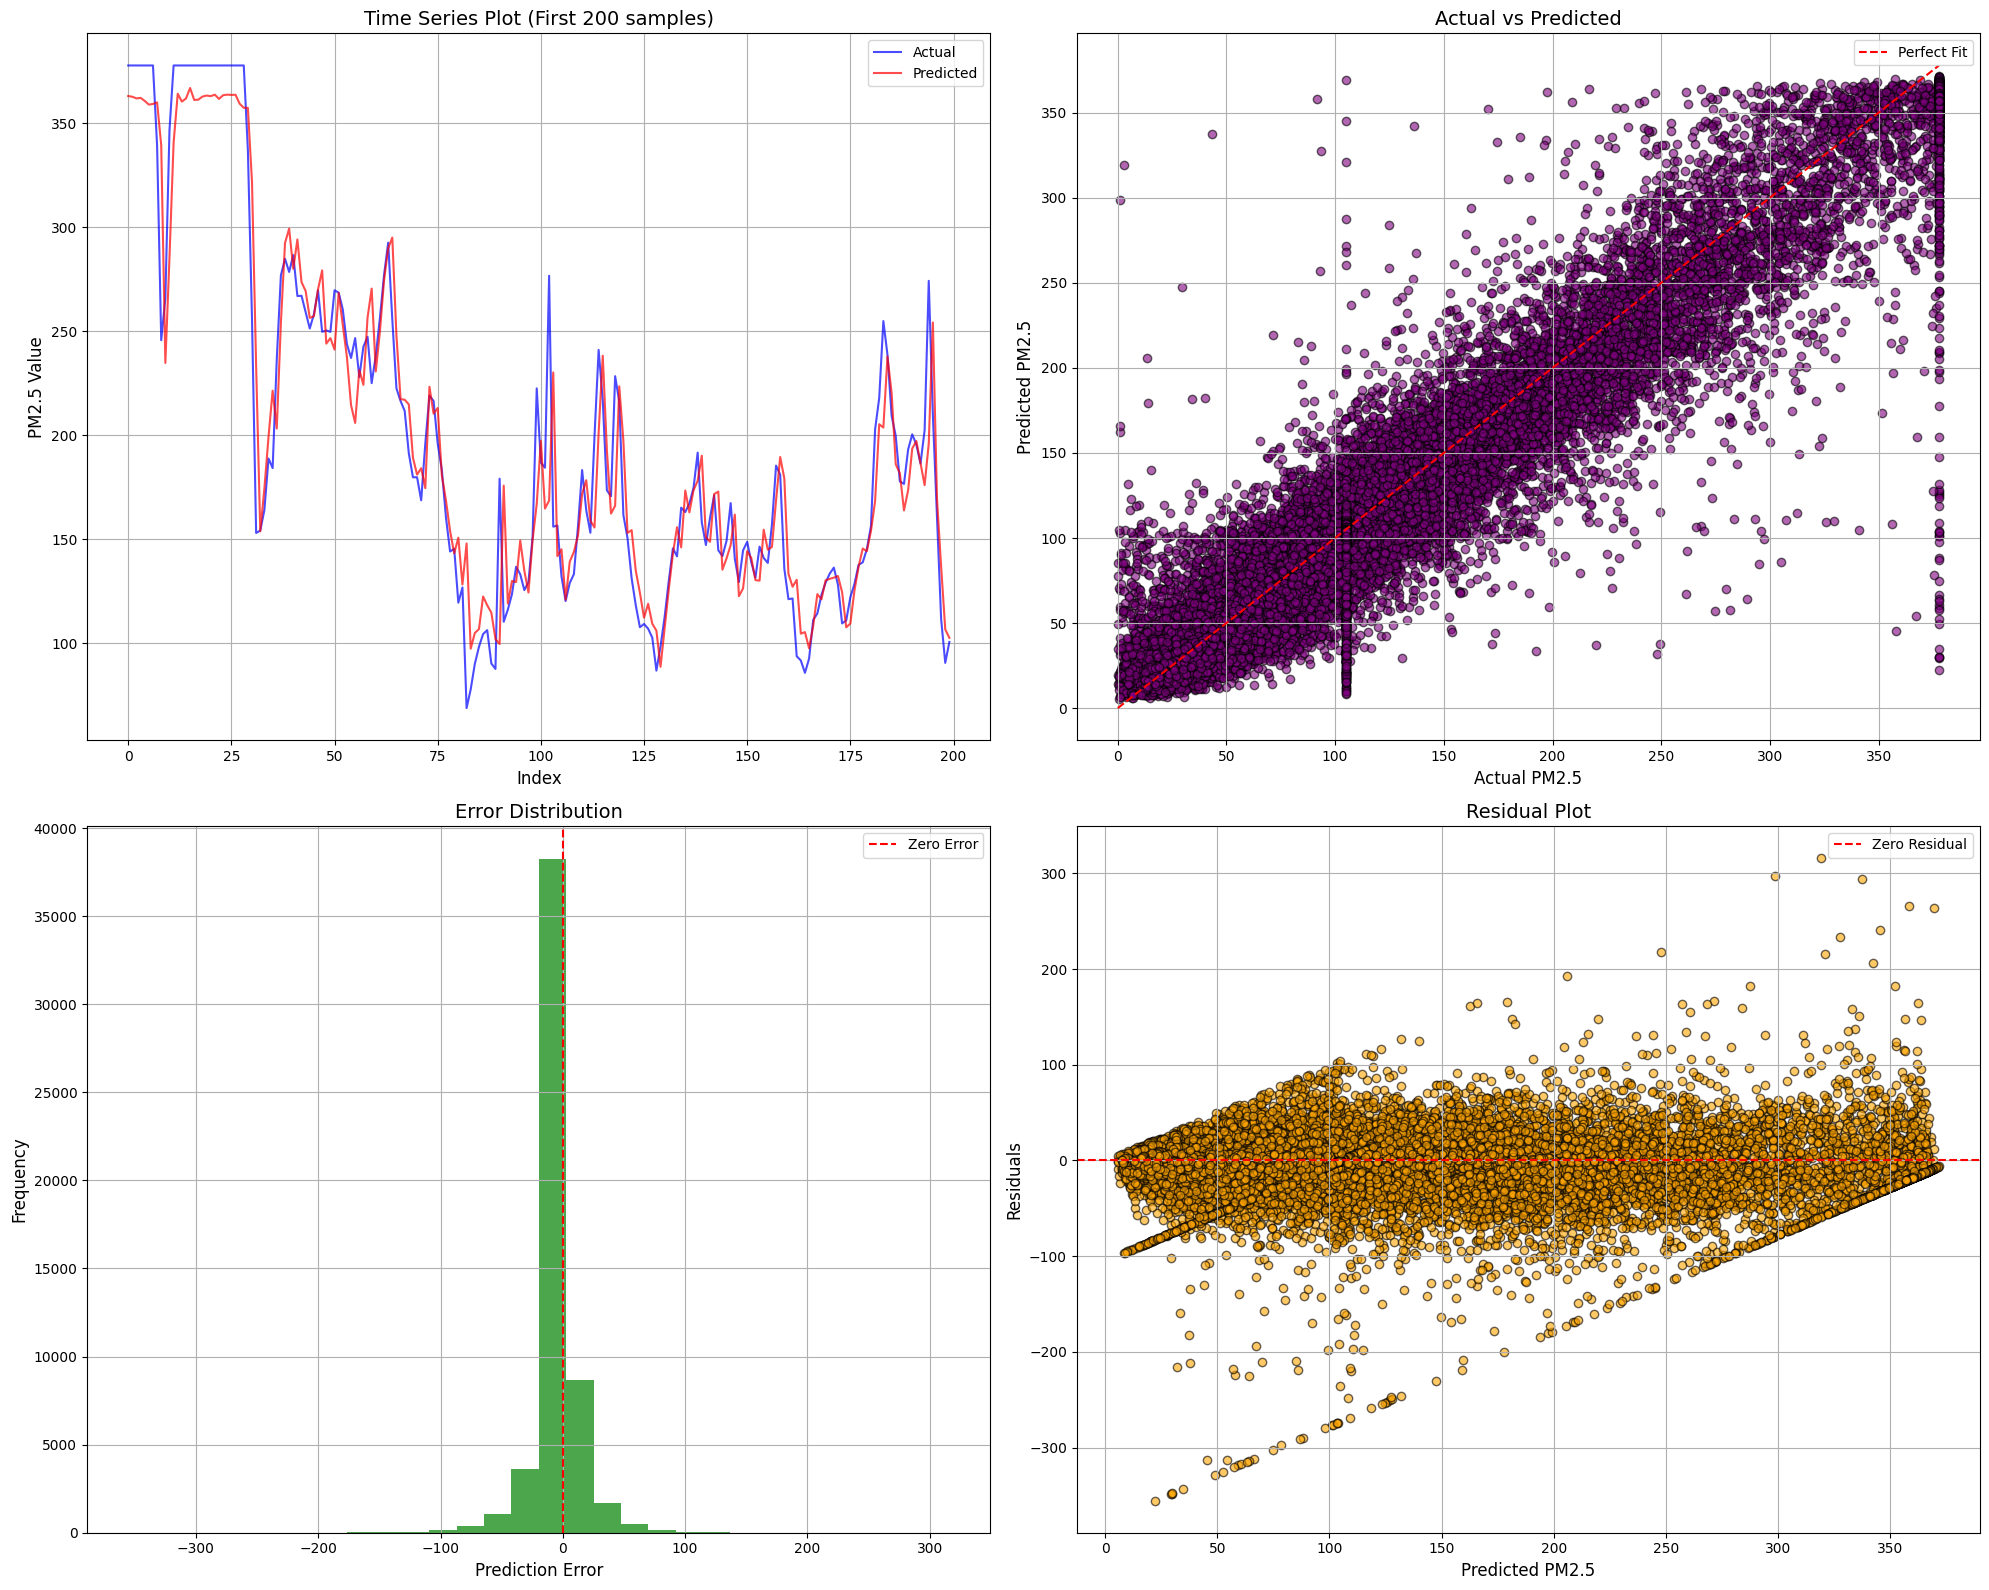

{'RMSE': 21.146222743735706,
 'MAE': 10.163111113464916,
 'R2': 0.9157279113872987,
 'MAPE': 24.87481072231499,
 'Mean Bias Error': -2.4968040401524387,
 'Max Error': 355.36369659473013,
 'Error Std': 20.998302453121386}

In [31]:

X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx = preprocess_data(
    "/kaggle/input/pm2-5-india/final_india_data.csv", sequence_length=24
)

# Train model and get predictions
model, history, predictions, actual = train_and_predict(
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx
)

# Save model artifacts
save_model_artifacts(model, scaler)

# Evaluate predictions
evaluate_predictions(actual, predictions)

In [33]:
X_train.shape

(255466, 24, 43)

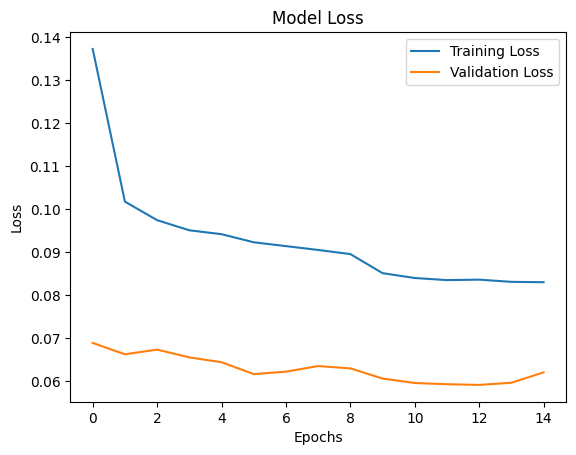

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()